### Load Packages

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import get_file
import matplotlib.pyplot as plt

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Overview
---

<img src="https://imgur.com/OVABmio.png" width="500">

We have three item images. We want to place a single image on the landing page to attract customer attention and click on the product page. 
**Which image can increase more clicks?**

In order to reproduce the marketing situation, the `simulator` class is implemented below.

In [4]:
class Simulator:
    fpath = get_file(
        'ads_simulation.csv',
        'https://docs.google.com/uc?id=1uHFOZ0DTHaX45f26xCbj_G3eptRblXiu')
    simulation_cases = pd.read_csv(fpath)
    def __init__(self):
        self.idx = 0
        self.selections = ["case1", "case2", "case3"]
    
    def choose(self, selection):
        assert selection in self.selections
        self.idx += 1
        idx = self.idx % 10000
        return bool(self.simulation_cases.loc[idx,selection])
    
simulator = Simulator()

The simulator `choose(case)` is a method that evaluates whether the customer clicked on the page or not after each exposure. With this simulator, we can collect customer's click results.


In [8]:
print(" Expose Case 1")
results = []
for i in range(10):
    reward = simulator.choose('case1')
    results.append(reward)
print("10 Trials : {} success / {} fail \n".format(sum(results), 10 - sum(results)))
    
print(" Expose Case 2")
results = []
for i in range(10):
    reward = simulator.choose('case1')
    results.append(reward)

print("10 Trials : {} success / {} fail \n".format(sum(results), 10 - sum(results)))

print(" Expose Case 3")
results = []
for i in range(10):
    reward = simulator.choose('case1')
    results.append(reward)
print("10 Trials : {} success / {} fail \n".format(sum(results), 10 - sum(results)))

 Expose Case 1
10 Trials : 1 success / 9 fail 

 Expose Case 2
10 Trials : 1 success / 9 fail 

 Expose Case 3
10 Trials : 0 success / 10 fail 



## Implements Thompson Sampling Algorithm
---

![](https://imgur.com/yF19bN0.png)

In [12]:
from scipy.stats import beta

class ThompsonSamplingAgent:
    def __init__(self, cases=["case1", "case2", "case3"]):
        self.params = pd.DataFrame(np.ones((3,2)),
                                   columns=['alpha','beta'], 
                                   index=cases)
        self._last_chosen = None
        
    def choose(self):
        """
        Derive optimal case through Thompson sampling
        """
        case_probs = { 
            case : np.random.beta(row.alpha, row.beta) 
            for case, row in self.params.iterrows()}
        
        chosen_case = max(case_probs.items(), 
                          key=lambda kv : kv[1])[0]
        
        self._last_chosen = chosen_case
        return chosen_case
    
    def update(self, reward):
        """
        Update parameters through click reward
        """
        if reward:
            # success
            self.params.loc[self._last_chosen, "alpha"] += 1
        else:
            # fail
            self.params.loc[self._last_chosen, "beta"] += 1
            
    def visualize_pdf(self, title=""):
        """
        Visualize PDF(probability density function) in each case
        """
        for name, row in self.params.iterrows():
            xs = np.linspace(0+1e-5,1-1e-5,200)
            ys = beta.pdf(xs, row.alpha, row.beta)
            plt.plot(xs,ys,label=name)
        plt.title(title)
        plt.legend()
        plt.show()
        
    def expectation(self):
        """
        Derive expectations for each case
        """
        alphas = self.params.alpha
        betas = self.params.beta
        return  alphas / (alphas + betas)

### Try simulation

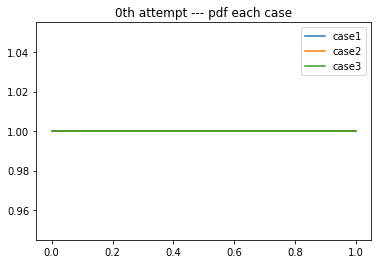

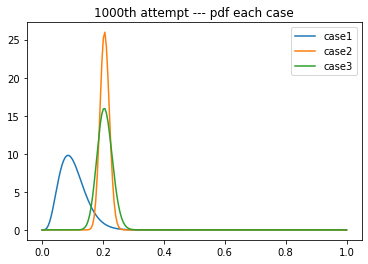

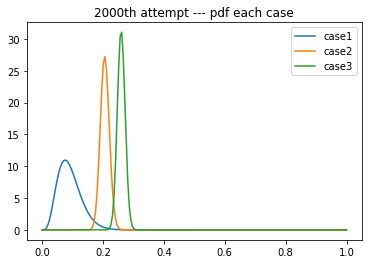

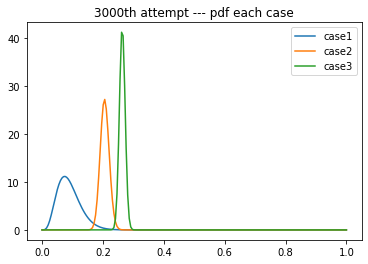

In [16]:
agent = ThompsonSamplingAgent()

history = []
for idx in range(0, 3000+1):
    # Visualization
    if idx % 1000 == 0:
        agent.visualize_pdf(f'{idx}th attempt --- pdf each case')
    chosen = agent.choose()
        
    # Update Distribution
    click = simulator.choose(chosen)
    
    # update Agent
    agent.update(click)
    
    # save expectation
    history.append(agent.expectation())

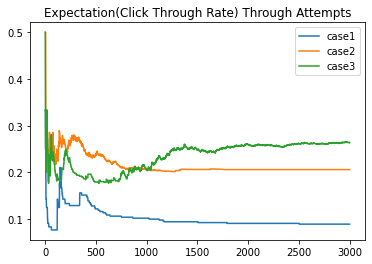

In [18]:
(
    pd.concat(history, axis=1).T
    .plot(title="Expectation(Click Through Rate) Through Attempts")
)
plt.show()